# Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import airportsdata

import warnings
warnings.filterwarnings("ignore")

In [2]:
airports = airportsdata.load('IATA')

def get_airport_location(airport_code):
    try:
        iata_code = airports[airport_code]['subd']
    except KeyError:
        if airport_code == 'PFN':
            iata_code = 'Florida'
        else:
            iata_code = 'Unknown'
    return iata_code

def season(month, day):
    # return the season based on month and day

    complete_num = f"{month}{day}"
    complete_num = int(complete_num)

    if 320 <= complete_num <= 620:
        return 'Spring'
    elif 621 <= complete_num <= 922:
        return 'Summer'
    elif 923 <= complete_num <= 1221:
        return 'Fall'
    else:
        return 'Winter'

In [3]:
data = pd.read_csv(f'data{os.sep}flight_delays_train.csv')
data.head()
df = data.copy()
df['Month'] = data['Month'].apply(lambda x: int(x.split('-')[1]))
df['DayofMonth'] = data['DayofMonth'].apply(lambda x: int(x.split('-')[1]))
df['DayOfWeek'] = data['DayOfWeek'].apply(lambda x: int(x.split('-')[1]))
df['DepTime'] = data['DepTime'].apply(lambda x: x % 2400)
df['DepTime'] = pd.qcut(x=df['DepTime'], q=4, labels=['Night', 'Morning', 'Afternoon', 'Evening'])
df['Distance'] = pd.qcut(x=data['Distance'], q=5, labels=['Very short', 'Short', 'Medium', 'Long', 'Very long'])
df['Origin'] = data['Origin'].apply(lambda x: get_airport_location(x))
df['Dest'] = data['Dest'].apply(lambda x: get_airport_location(x))
df['Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x in [6, 7] else 0)
df['Season'] = df.apply(lambda x: season(x['Month'], x['DayofMonth']), axis=1)
df['dep_delayed_15min'] = df['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)
df.rename(columns={'dep_delayed_15min': 'Delayed'}, inplace=True)
df = df.reindex(columns=['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'Origin', 'Dest', 'UniqueCarrier', 'Weekend', 'Season', 'Delayed'])

# Maximum Likelihood Estimator

In [4]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Creating train e test

In [5]:
Y = df["Delayed"]
X = df.drop("Delayed", axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y)

## Creating a naive bayes network

In [6]:
columns = list(df.columns)
network = [("Delayed", x) for x in columns[:-1]]
nb_model = BayesianNetwork(network)

## Creating the estimator on the train set and applying its result to our network

In [7]:
estimator = MaximumLikelihoodEstimator(nb_model, xtrain.join(ytrain))

In [8]:
for _ in estimator.get_parameters():
    nb_model.add_cpds(_)

/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)


## Make a prediction based on the CPDS given

In [9]:
ypred = nb_model.predict(xtest)

  0%|          | 0/24857 [00:00<?, ?it/s]

100%|██████████| 24857/24857 [00:36<00:00, 683.97it/s]


In [10]:
accuracy_score(ypred, ytest)

0.81056

In [11]:
roc_auc_score(ytest, ypred, average="weighted")

0.5199248110289978

# Bayesian estimator

In [12]:
from pgmpy.estimators import BayesianEstimator

In [13]:
nb_model = BayesianNetwork(network)

In [14]:
estimator = BayesianEstimator(nb_model, xtrain.join(ytrain))

In [15]:
for _ in estimator.get_parameters():
    nb_model.add_cpds(_)

/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)


In [16]:
ypred = nb_model.predict(xtest)

  0%|          | 0/24857 [00:00<?, ?it/s]

100%|██████████| 24857/24857 [00:39<00:00, 625.90it/s]


In [17]:
accuracy_score(ypred, ytest)

0.81056

In [18]:
roc_auc_score(ytest, ypred, average="weighted")

0.5199248110289978

# Dropping some columns

In [19]:
to_drop = ["Month", "DayofMonth", "DayOfWeek", "Distance"]
df_dropped = df.drop(labels=to_drop, axis=1)

columns = list(df_dropped.columns)
network = [("Delayed", x) for x in columns[:-1]]
nb_model = BayesianNetwork(network)

Y = df_dropped["Delayed"]
X = df_dropped.drop("Delayed", axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y)

In [20]:
estimator = MaximumLikelihoodEstimator(nb_model, xtrain.join(ytrain))
for _ in estimator.get_parameters():
    nb_model.add_cpds(_)

/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)


In [21]:
ypred = nb_model.predict(xtest)

  0%|          | 0/16339 [00:00<?, ?it/s]

100%|██████████| 16339/16339 [00:17<00:00, 932.30it/s] 


In [22]:
accuracy_score(ypred, ytest)

0.81544

In [23]:
roc_auc_score(ytest, ypred, average="weighted")

0.5117791120428491

# Custom acustic network

In [24]:
df.columns
Y = df["Delayed"]
X = df.drop("Delayed", axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y)

In [25]:
network = [
    ("Delayed", "UniqueCarrier"),
    ("Delayed", "DepTime"),
    ("DepTime", "Season"),
    ("DepTime", "DayOfWeek"),
    ("DepTime", "Weekend"),
    ("DepTime", "DayofMonth"),
    ("DepTime", "Month"),
    ("Distance", "Origin"),
    ("Distance", "Dest")
]

In [26]:
nb_model = BayesianNetwork(network)

In [27]:
estimator = BayesianEstimator(nb_model, xtrain.join(ytrain))

for _ in estimator.get_parameters():
    nb_model.add_cpds(_)

/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/sbrodox/Scrivania/BayesianClassifier/env/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True i

In [28]:
ypred = nb_model.predict(xtest)

  0%|          | 0/24870 [00:00<?, ?it/s]

 12%|█▏        | 3056/24870 [00:04<00:34, 628.65it/s]WARNING:pgmpy:Found unknown state name. Trying to switch to using all state names as state numbers


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
accuracy_score(ytest, ypred)

0.80728

In [ ]:
roc_auc_score(ytest, ypred, average="weighted")

0.5

 # Learning from data
 #### In collaboration with google gemini

In [29]:
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch

# PC

In [30]:
to_drop = ["Month", "DayofMonth"]
df_dropped = df.drop(labels=to_drop, axis=1)

columns = list(df_dropped.columns)
network = [("Delayed", x) for x in columns[:-1]]
nb_model = BayesianNetwork(network)

Y = df_dropped["Delayed"]
X = df_dropped.drop("Delayed", axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y)

In [ ]:
warnings.filterwarnings("INFO")

In [31]:
est = PC(data=df_dropped)
estimated_model = est.estimate(variant="stable", max_cond_vars=2)

INFO:pgmpy:Skipping the test DayOfWeek ⟂ DepTime | Dest=Delaware. Not enough samples
INFO:pgmpy:Skipping the test DayOfWeek ⟂ DepTime | Origin=Delaware. Not enough samples
INFO:pgmpy:Skipping the test DayOfWeek ⟂ DepTime | Dest=Delaware. Not enough samples
INFO:pgmpy:Skipping the test DayOfWeek ⟂ DepTime | Origin=Delaware. Not enough samples
INFO:pgmpy:Skipping the test DepTime ⟂ Distance | Dest=Delaware. Not enough samples
INFO:pgmpy:Skipping the test DepTime ⟂ Distance | Dest=Hawaii. Not enough samples
INFO:pgmpy:Skipping the test DepTime ⟂ Distance | Dest=Kansas. Not enough samples
INFO:pgmpy:Skipping the test DepTime ⟂ Distance | Dest=Mississippi. Not enough samples
INFO:pgmpy:Skipping the test DepTime ⟂ Distance | Dest=Nebraska. Not enough samples
INFO:pgmpy:Skipping the test DepTime ⟂ Distance | Dest=Puerto Rico. Not enough samples
 12%|█▏        | 3056/24870 [00:22<00:34, 628.65it/s]INFO:pgmpy:Skipping the test DepTime ⟂ Distance | Dest=South Carolina. Not enough samples
INFO:pg

In [32]:

import networkx as nx

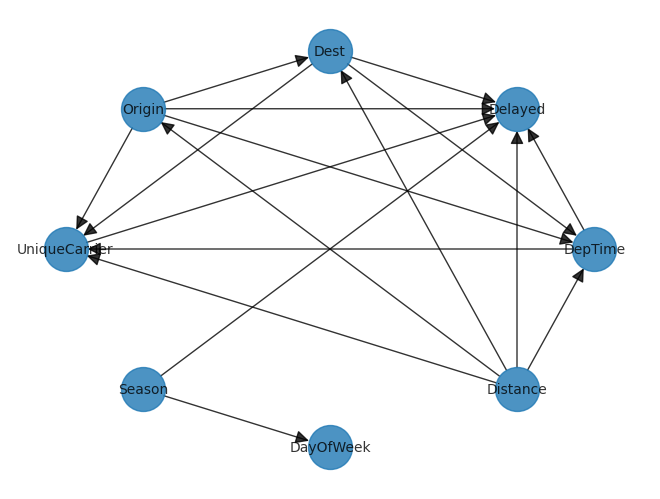

In [33]:
nx.draw_circular(estimated_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [34]:
estimated_model.predict()

AttributeError: 'DAG' object has no attribute 'predict'